# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
## Εργασία 1. Επιβλεπόμενη Μάθηση
Δημήτριος Καλαθάς - el18016 <br>
Δημήτριος Μπακάλης - el18163<br>
Δημήτριος Καλέμης - el18152

# Μέρος 2. Kaggle Dataset (Cyberattacks)

## Περιγραφή του dataset: 

Στο πλαίσιο του 2ου μέρους της εργασίας θα ασχοληθούμε με το dataset για cyberattacks του Kaggle. Σκοπός του συγκεκριμένου dataset είναι να ανιχνευθούν διάφορες ύποπτες συνδέσεις. Πιο συγκεκριμένα το σύνολο δεδομένων περιέχει συνολικά 494.021 δείγματα συνδέσεων, η κάθε μία, εκ των οποίων, περιγράφεται από 41 χαρακτηριστικά (πχ διάρκεια σύνδεσης, τύπος πρωτοκόλλου, υπηρεσία πρωτοκόλλου, flag πρωτοκόλλου κλπ) και ένα label, το οποίο προσδιορίζει αν η συγκεκριμένη τον τύπο της σύνδεσης (κανονική (normal) ή κάποιος τύπος επίθεσης (22 συνολικά)). 

Πέρα από τα 3 χαρακτηριστικά "τύπος πρωτοκόλλου", "υπηρεσία πρωτοκόλλου", "flag πρωτοκόλλου", τα οποία έχουν string δεδομένα, τα υπόλοιπα λαμβάνουν τιμή integer ή float αριθμού. Αξίζει να σημειωθεί πως στο συγκεκριμένο dataset, σε αντίθεση με το προηγούμενο, δεν έχουμε missing values. 

Επιπλέον, λόγω του μεγάλου όγκου των δεδομένων και των περιορισμένων πόρων που διαθέτουμε, θα λάβουμε υπόψιν μόλις το 5% των συνολικών δεδομένων, καθώς τα 24.701 δείγματα είναι επαρκή για μία καλή λύση, τόσο ως προς την βελτιστοποίηση των ζητούμενων μετρικών, όσο και σε θέμα υπολογιστικής πολυπλοκότητας. Τα δείγματα αυτά επιλέγονται στοχαστικά μέσω της sample της βιβλιοθήκης pandas.  

In [1]:
import numpy as np
import pandas as pd 
import os
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import time
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

In [2]:
!pip install -U ray 
!pip install -U ray[tune]
!pip install -U tune-sklearn
from tune_sklearn import TuneGridSearchCV
import ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.0.0
    Uninstalling ray-2.0.0:
      Successfully uninstalled ray-2.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.1 MB/s eta 0:00:00


# Εισαγωγή των δεδομένων και preprocessing:

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)

df = pd.read_csv(path, header = None)

features_df = df.iloc[:, :-1]
features = features_df.values

labels_df = df.iloc[:, [-1]]
labels = labels_df.values
labels = labels.reshape((labels.shape[0]))

Παρακάτω φαίνεται η κατανομή των δειγμάτων ανά κλάση, η οποία είναι αρκετά άνιση. Παρατηρείται, πως ορισμένες κλάσεις έχουν πολύ μεγάλο αριθμό δεδομένων (normal, neptune, smurf), ενώ οι υπόλοιπες έχουν σημαντικά λιγότερα (εώς και αμελητέα) δείγματα.

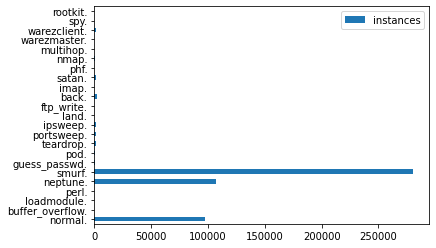

In [5]:
distinct_labels = []
for label in labels:
    if label not in distinct_labels:
        distinct_labels.append(label)
    else:
        continue

cnt = 23*[0]
for label in labels:
    for i, dlabel in enumerate(distinct_labels):
        if label == dlabel:
            cnt[i] += 1

df = pd.DataFrame({'instances': cnt}, index=distinct_labels)
ax = df.plot.barh()

## Οπτικοποίηση των attributes τύπου string:

Από τη στιγμή που το αρχείο δεν είχε column names, ορίζουμε μια λίστα columns, η οποία περιέχει τα ονόματα των στηλών του συνόλου δεδομένων. Τα ονόματα αυτά, βρίσκονται στο documentation του dataset.

In [6]:
columns = ["duration", "protocoltype", "service", "flag", "srcbytes", "dstbytes", "land", "wrongfragment",
           "urgent", "hot", "numfailedlogins", "loggedin", "numcompromised", "rootshell", "suattempted",
           "numroot", "numfilecreations", "numshells", "numaccessfiles", "numoutboundcmds", "ishostlogin",
           "isguestlogin", "count", "srvcount", "serrorrate", "srvserrorrate", "rerrorrate", "srvrerrorrate",
           "samesrvrate", "diffsrvrate", "srvdiffhostrate", "dsthostcount", "dsthostsrvcount",
           "dsthostsamesrvrate", "dsthostdiffsrvrate", "dsthostsamesrcportrate", "dsthostsrvdiffhostrate",
           "dsthostserrorrate", "dsthostsrvserrorrate", "dsthostrerrorrate", "dsthostsrvrerror_rate", "labels"]

df = pd.read_csv(path, header = None, names = columns)

Στα παρακάτω διαγράμματα, φαίνονται τα χαρακτηριστικά τύπου string του dataset ("protocoltype", "service", "flag"), και ο αντίστοιχος αριθμός δειγμάτων.

Text(0, 0.5, 'Count')

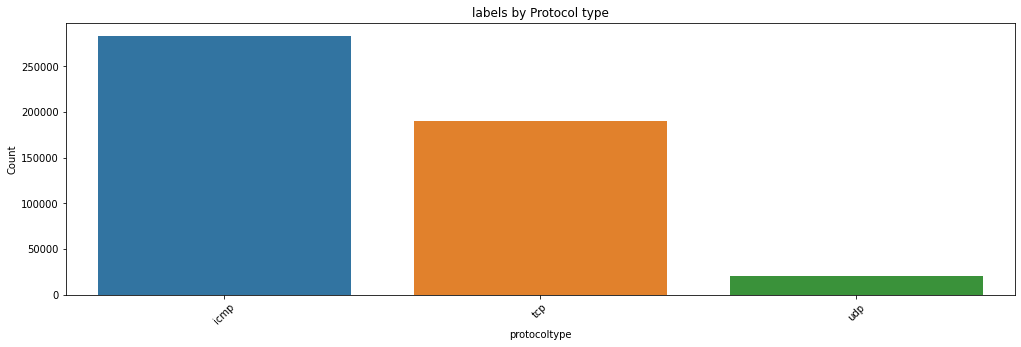

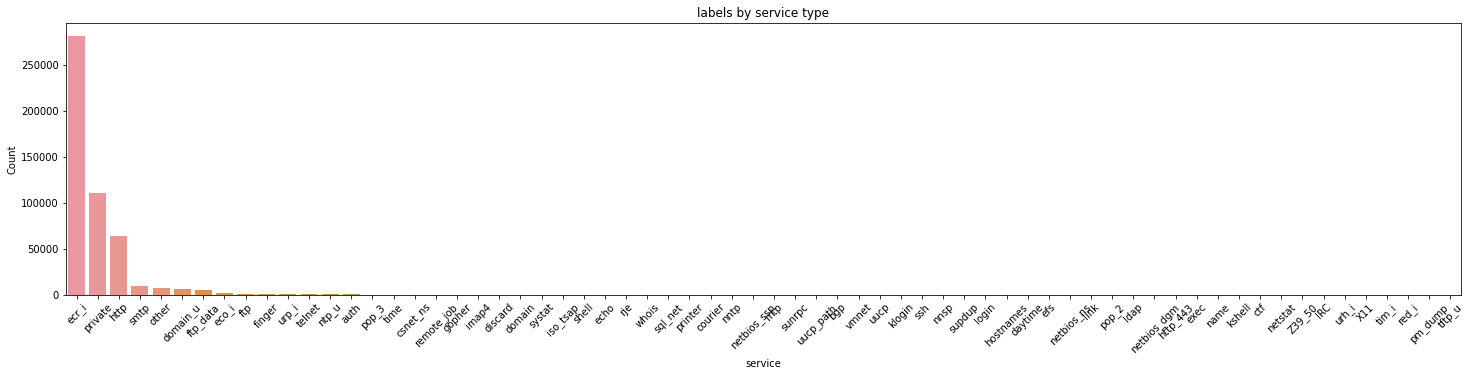

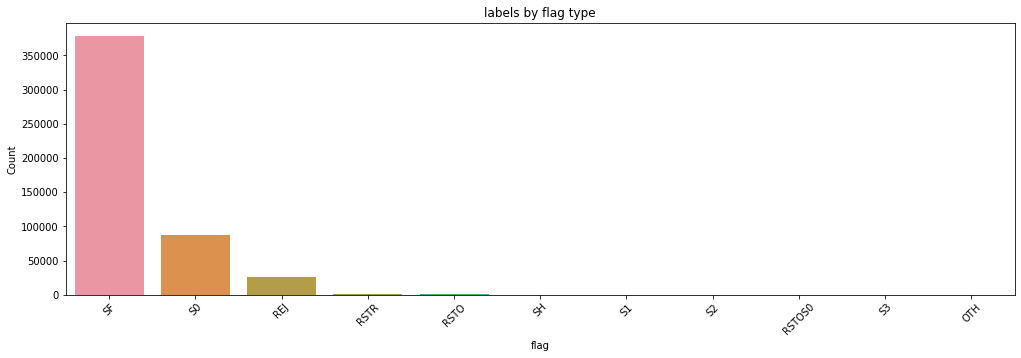

In [7]:
import seaborn as sns

grouped_labels = df.groupby("protocoltype")["protocoltype"].count().sort_values(ascending=False)

f = plt.figure()
plt.xticks(rotation=45)

f.set_figwidth(17)
f.set_figheight(5)
sns.barplot(x=grouped_labels.index, y=grouped_labels.values)
plt.title("labels by Protocol type")
plt.ylabel("Count")


grouped_labels = df.groupby("service")["service"].count().sort_values(ascending=False)

f = plt.figure()
plt.xticks(rotation=45)

f.set_figwidth(25)
f.set_figheight(5)
sns.barplot(x=grouped_labels.index, y=grouped_labels.values)
plt.title("labels by service type")
plt.ylabel("Count")


grouped_labels = df.groupby("flag")["flag"].count().sort_values(ascending=False)

f = plt.figure()
plt.xticks(rotation=45)

f.set_figwidth(17)
f.set_figheight(5)
sns.barplot(x=grouped_labels.index, y=grouped_labels.values)
plt.title("labels by flag type")
plt.ylabel("Count")




Στη συνέχεια, θα επεξεργαστούμε τα συγκεκριμένα χαρακτηριστικά προσθέτοντας m νέα binary χαρακτηριστικά (σε περίπτωση που απλά αριθμούσαμε τις ήδη υπάρχουσες τιμές από 0 εώς m στο ίδιο χαρακτηριστικό θα είχαμε μια μορφή διάταξης, που θα λειτουργούσε αρνητικά στην επίδοση των αλγορίθμων), όπως περιγράφεται και στα notebooks του εργαστηρίου. Επισημαίνεται ξανά, πως προκειμένου να μειώσουμε τη πολυπλοκότητα και το χρόνο εκπαίδευσης, παίρνουμε μόνο ένα μικρό μέρος του dataset (5% του συνολικού).

In [8]:
# save a copy of the full dataframe
df_full = df.copy()

# get a part of the dataframe - less complexity and train time
df = df.sample(frac=0.05, random_state=0)

features_df = df.iloc[:, :-1]

enc_protocol = pd.get_dummies(features_df["protocoltype"], prefix="protocol_")
enc_service = pd.get_dummies(features_df["service"], prefix="service_")
enc_flag = pd.get_dummies(features_df["flag"], prefix="flag_")

features_df.drop("protocoltype", axis=1, inplace=True)
features_df.drop("service", axis=1, inplace=True)
features_df.drop("flag", axis=1, inplace=True)

features_df = pd.concat([features_df, enc_protocol, enc_service, enc_flag], axis=1)

features = features_df.values

labels_df = df.iloc[:, [-1]]
labels = labels_df.values
labels = labels.reshape((labels.shape[0]))

#code from https://www.kaggle.com/code/sergeyplatonov98/multi-class-network-traffic-classfier

Στο πλαίσιο της εργασίας θα προσπαθήσουμε να διαφοροποιήσουμε ελαφρώς το πρόβλημα (σύμφωνα και με την αντίστοιχη βιβλιογραφία), προκειμένου να εξάγουμε καλά αποτελέσματα και να περιορίσουμε τα προβλήματα, που εγκυμονεί ένα imbalanced dataset. Η πρώτη προσέγγιση θα είναι η αναγωγή σε **binary classification**, ενώ η δεύτερη σε **multiclass classification**.

# Binary classification (normal, attack)

Θα επιχειρήσουμε να δώσουμε μια λύση σε μία αρκετά απλοποιημένη περίπτωση του προβλήματος, ενοποιώντας όλους τους τύπους επιθέσεων σε έναν γενικό (attack). Επομένως, στην πρώτη λύση του προβλήματος, το ανάγουμε σε binary classification μεταξύ 'normal' και  'attack' συνδέσεων.

## Μετατροπή των labels:

Διαχωρίζουμε το dataset σε train (70%) και test (30%) sets ώστε να πραγματοποιηθεί η εκπαίδευση των ταξινομητών, ορίζουμε τις δυο μεγάλες κατηγορίες και μετασχηματίζουμε τα values των labels στις κατηγορίες αυτές.

In [9]:
binary_labels = labels.copy()
for i, label in enumerate(binary_labels):
    if label != 'normal.':
        binary_labels[i] = 'attack.'
        
x_train, x_test, y_train, y_test = train_test_split(features, binary_labels, test_size=0.3)

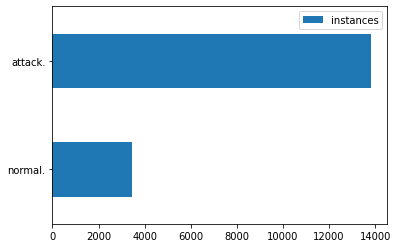

In [10]:
# plot binary labels of train set
distinct_labels_bin = ['normal.', 'attack.']

cnt2 = len(distinct_labels_bin)*[0]
# plot instances of train set only
for label in y_train:
    for i, dlabel in enumerate(distinct_labels_bin):
        if label == dlabel:
            cnt2[i] += 1

df = pd.DataFrame({'instances': cnt2}, index=distinct_labels_bin)
ax = df.plot.barh()

Από το παραπάνω διάγραμμα, είναι φανερό πως το classification έχει αναχθεί σε binary classification. Οι δύο κλάσεις έχουν αρκετά μεγάλο αριθμό δειγμάτων, συνεπώς επιτεύχθηκε μια πιο ισορροπημένη μορφή του dataset.

Αρχικοποιούμε κάποιους transormers για να βελτιστοποιήσουμε τις υπερπαραμέτρους των παρακάτω μοντέλων.

**selector**: Χρησιμοποιήσουμε τη συνάρτηση VarianceThreshold για να αφαιρέσουμε τα χαρακτηριστικά στο training set που έχουν μηδενική διακύμανση (default) ή πολύ χαμηλή. 

**scaler**: Χρησιμοποιούμε τον StandardScaler για κανονικοποίηση χαρακτηρηστικών, ακολουθώντας κανονική κατανομή N(0, 1)

**ros**: Χρησιμοποιούμε τον RandomOverSampler για την εξισορρόπηση του dataset

**pca**: Χρησιμοποιύμε τη μέθοδο PCA με εξαγωγή νέων χαρακτηριστικών για τη μείωση των διαστάσεων

In [11]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

## Multi-Layer Perceptron (MLP)

Ο πρώτος ταξινομητής υλοποιείται με Multi-Layer Perceptron (MLP) out-of-the-box, δηλαδή με τις default παραμέτρους. Έπειτα, με τη χρήση pipeline των transformer (pca, ros) που αναφέρθηκαν παραπάνω, επιδιώκουμε την εύρεση των βέλτιστων υπερπαραμέτρων για τη μεγιστοποίηση του accuracy και του f1 score ξεχωριστά. Επιπρόσθετα, με την αξιοποίηση της TuneGridSearchCV (από την βιβλιοθήκη της ray) πραγματοποιείται το cross validation, από το οποίο εξάγουμε τις optimal τιμές των υπερπαραμέτρων.

### Out-of-the-box

In [12]:
mlp_ootb = MLPClassifier()
start_time = time.time()
mlp_ootb.fit(x_train, y_train)
mlp_ootb_preds = mlp_ootb.predict(x_test)

mlp_ootb_time = time.time() - start_time
print("Total time for fit and predict: %s seconds" % (mlp_ootb_time))

mlp_ootb_acc = accuracy_score(y_test, mlp_ootb_preds)
mlp_ootb_f1 = f1_score(y_test, mlp_ootb_preds, average = 'macro')

print("\nMulti-Layer Perceptron out-of-the-box performance:")
print(classification_report(y_test, mlp_ootb_preds))

Total time for fit and predict: 7.7754905223846436 seconds

Multi-Layer Perceptron out-of-the-box performance:
              precision    recall  f1-score   support

     attack.       0.99      0.99      0.99      5916
     normal.       0.98      0.97      0.98      1495

    accuracy                           0.99      7411
   macro avg       0.99      0.98      0.98      7411
weighted avg       0.99      0.99      0.99      7411



<AxesSubplot:>

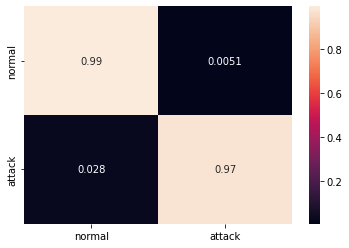

In [13]:
cm = confusion_matrix(y_test, mlp_ootb_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Αναφορικά με την out of the box MLP (binary), παρατηρούνται σχετικά υψηλές τιμές f1 score και accuracy. Συνεπώς, ακόμα και με τις default παραμέτρους, ο ταξινομητής διαχωρίζει με αρκετή ακρίβεια τη φύση του δείγματος (normal ή attack). Στο ίδιο συμπέρασμα καταλήγουμε και μέσω της παρατήρησης του αντίστοιχου confusion matrix, από τη στιγμή που η μεγάλη  η πλειοψηφία των στοιχείων του εντοπίζονται στη διαγώνιο, ενώ υπάρχουν ελάχιστα misclassifications.

### Tuned

Οι υπερπαράμετροι των tuned μοντέλων εξηγούνται παρακάτω:
* **n_components:** αριθμός νέων, γραμμικά ασυσχέτιστων μεταβλητών μικρότερης διαστατικότητας
* **activation:** συνάρτηση ενεργοποίησης
* **learning_rate_init:** αρχικοποίηση του ρυθμού μάθησης (μεταβολής των βαρών) του mlp

In [14]:
n_components = [10, 30, 50]
activation = ['relu', 'logistic']
learning_rate_init = [0.01, 0.001, 0.0001]

mlp = MLPClassifier(learning_rate = 'invscaling')
pipe_mlp = Pipeline(steps=[('pca', pca), ('sampler', ros), ('mlp', mlp)])

#### Optimal f1 score:

In [15]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
mlp_optimal_f1 = TuneGridSearchCV(pipe_mlp,  dict(pca__n_components=n_components, mlp__activation=activation, mlp__learning_rate_init=learning_rate_init), max_iters=5, cv=10, scoring='f1_macro')
mlp_optimal_f1.fit(x_train, y_train)
mlp_optimal_f1_time = mlp_optimal_f1.refit_time_

print("\nMulti-Layer Perceptron tuned for optimal f1 performance:")
print(mlp_optimal_f1.best_params_)

start_time = time.time()
mlp_optimal_f1_preds = mlp_optimal_f1.predict(x_test)
mlp_optimal_f1_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (mlp_optimal_f1_time))

mlp_optimalf1_acc = accuracy_score(y_test, mlp_optimal_f1_preds)
mlp_optimalf1_f1 = f1_score(y_test, mlp_optimal_f1_preds, average = 'macro')
print(classification_report(y_test, mlp_optimal_f1_preds))


Multi-Layer Perceptron tuned for optimal f1 performance:
{'pca__n_components': 50, 'mlp__activation': 'logistic', 'mlp__learning_rate_init': 0.0001}

Total time for fit and predict: 81.80410885810852 seconds
              precision    recall  f1-score   support

     attack.       1.00      0.99      1.00      5916
     normal.       0.98      1.00      0.99      1495

    accuracy                           1.00      7411
   macro avg       0.99      1.00      0.99      7411
weighted avg       1.00      1.00      1.00      7411



<AxesSubplot:>

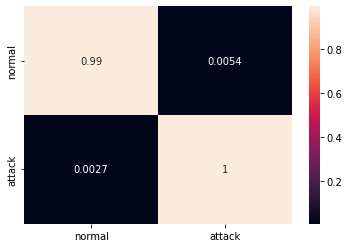

In [16]:
cm = confusion_matrix(y_test, mlp_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

#### Optimal accuracy score: 

In [17]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
mlp_optimal_acc = TuneGridSearchCV(pipe_mlp,  dict(pca__n_components=n_components, mlp__activation=activation, mlp__learning_rate_init=learning_rate_init), max_iters=5, cv=10, scoring='accuracy')
mlp_optimal_acc.fit(x_train, y_train)
mlp_optimal_acc_time = mlp_optimal_acc.refit_time_

print("\nMulti-Layer Perceptron tuned for optimal accuracy performance:")
print(mlp_optimal_acc.best_params_)

start_time = time.time()
mlp_optimal_acc_preds = mlp_optimal_acc.predict(x_test)
mlp_optimal_acc_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (mlp_optimal_acc_time))

mlp_optimalacc_acc = accuracy_score(y_test, mlp_optimal_acc_preds)
mlp_optimalacc_f1 = f1_score(y_test, mlp_optimal_acc_preds, average = 'macro')
print(classification_report(y_test, mlp_optimal_acc_preds))


Multi-Layer Perceptron tuned for optimal accuracy performance:
{'pca__n_components': 50, 'mlp__activation': 'logistic', 'mlp__learning_rate_init': 0.0001}

Total time for fit and predict: 65.97702312469482 seconds
              precision    recall  f1-score   support

     attack.       1.00      0.99      1.00      5916
     normal.       0.97      1.00      0.98      1495

    accuracy                           0.99      7411
   macro avg       0.99      0.99      0.99      7411
weighted avg       0.99      0.99      0.99      7411



<AxesSubplot:>

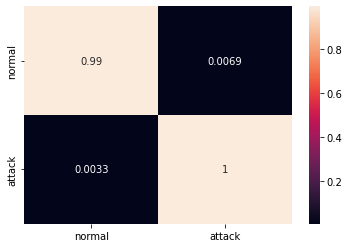

In [18]:
cm = confusion_matrix(y_test, mlp_optimal_acc_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Στις Tuned υλοποιήσεις του MLP (μία για βελτιστοποίηση του f1 score και μια για βελτιστοποίηση του accuracy), παρατηρείται αύξηση των μετρικών f1 score και accuracy σε σχέση με τον αντίστοιχo out of the box. Επομένως, η εύρεση βέλτιστων παραμέτρων αύξησε την αποδοτικότητα του ταξινομητή. Αυτό επιβεβαιώνεται και με την ανασκόπηση των confusion matrixes, μιας και τα δεδομένα που είναι misclassified, είναι ακόμη λιγότερα στα tuned από ότι στο out of the box.

## Support Vector Machine (SVM)

Εδώ, γίνεται χρήση του Support Vector Machine (SVM) out-of-the-box, δηλαδή με τις default παραμέτρους. Στη συνέχεια, με τη χρήση pipeline των transformer (pca) που αναφέρθηκαν παραπάνω, επιδιώκουμε την εύρεση των βέλτιστων υπερπαραμέτρων για τη μεγιστοποίηση του accuracy και του f1 score ξεχωριστά. Επίσης χρησιμοποιούμε την TuneGridSearchCV από την βιβλιοθήκη της ray για να κάνουμε το grid-search, που θα μας δώσει τελίκα τις optimal τιμές των μετρικών μας.

### Out-of-the-box

In [19]:
svm_ootb = SVC()
start_time = time.time()
svm_ootb.fit(x_train, y_train)
svm_ootb_preds = svm_ootb.predict(x_test)

svm_ootb_time = time.time() - start_time
print("Total time for fit and predict: %s seconds" % (svm_ootb_time))

svm_ootb_acc = accuracy_score(y_test, svm_ootb_preds)
svm_ootb_f1 = f1_score(y_test, svm_ootb_preds, average = 'macro')

print("\nSupport Vector Machine out-of-the-box performance:")
print(classification_report(y_test, svm_ootb_preds))

Total time for fit and predict: 28.232895135879517 seconds

Support Vector Machine out-of-the-box performance:
              precision    recall  f1-score   support

     attack.       0.86      1.00      0.92      5916
     normal.       0.99      0.36      0.53      1495

    accuracy                           0.87      7411
   macro avg       0.92      0.68      0.73      7411
weighted avg       0.89      0.87      0.84      7411



<AxesSubplot:>

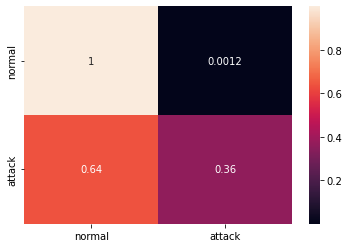

In [20]:
cm = confusion_matrix(y_test, svm_ootb_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Αναφορικά με το out of the box SVM (binary), δεν έχουμε αρκετά ικανοποιητικά αποτελέσματα. Πιο συγκεκριμένα, με τις default παραμέτρους, ο ταξινομητής κάνει πολλά misclassifications, εντάσσοντας attack δείγματα στη κατηγορία normal (παρατήρηση του cell [2,1] του confussion matrix). 

### Tuned

Οι υπερπαράμετροι των tuned μοντέλων εξηγούνται παρακάτω:
* **n_components:** αριθμός νέων, γραμμικά ασυσχέτιστων μεταβλητών μικρότερης διαστατικότητας
* **kernel:** Τύπος πυρήνα
* **C:** Παράμετρος κανονικοποίησης

In [21]:
pca = PCA(whiten=True)
svm = SVC()
pipe_svm = make_pipeline(pca, svm)
parameter_grid = {'pca__n_components': [10, 30, 50],
              'svc__kernel': ['linear', 'rbf'],
              'svc__C': [10, 20, 30]}

#### Optimal f1 score:

In [22]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
svm_optimal_f1 = TuneGridSearchCV(pipe_svm, parameter_grid, max_iters=5, cv=10, scoring='f1_macro')
svm_optimal_f1.fit(x_train, y_train)
svm_optimal_f1_time = svm_optimal_f1.refit_time_

print("\nSupport Vector Machine tuned for optimal f1 performance:")
print(svm_optimal_f1.best_params_)

start_time = time.time()
svm_optimal_f1_preds = svm_optimal_f1.predict(x_test)
svm_optimal_f1_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (svm_optimal_f1_time))

svm_optimalf1_acc = accuracy_score(y_test, svm_optimal_f1_preds)
svm_optimalf1_f1 = f1_score(y_test, svm_optimal_f1_preds, average = 'macro')
print(classification_report(y_test, svm_optimal_f1_preds))


Support Vector Machine tuned for optimal f1 performance:
{'pca__n_components': 50, 'svc__kernel': 'linear', 'svc__C': 20}

Total time for fit and predict: 6.290948390960693 seconds
              precision    recall  f1-score   support

     attack.       1.00      1.00      1.00      5916
     normal.       0.99      0.99      0.99      1495

    accuracy                           1.00      7411
   macro avg       0.99      0.99      0.99      7411
weighted avg       1.00      1.00      1.00      7411



<AxesSubplot:>

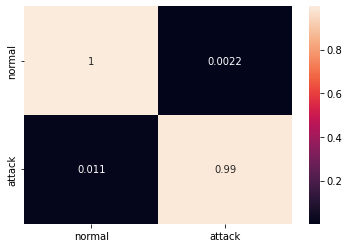

In [23]:
cm = confusion_matrix(y_test, svm_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

#### Optimal accuracy score:

In [24]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
svm_optimal_acc = TuneGridSearchCV(pipe_svm, parameter_grid, max_iters=5, cv=10, scoring='accuracy')
svm_optimal_acc.fit(x_train, y_train)
svm_optimal_acc_time = svm_optimal_acc.refit_time_

print("\nSupport Vector Machine tuned for optimal accuracy performance:")
print(svm_optimal_acc.best_params_)

start_time = time.time()
svm_optimal_acc_preds = svm_optimal_acc.predict(x_test)
svm_optimal_acc_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (svm_optimal_acc_time))

svm_optimalacc_acc = accuracy_score(y_test, svm_optimal_acc_preds)
svm_optimalacc_f1 = f1_score(y_test, svm_optimal_acc_preds, average = 'macro')
print(classification_report(y_test, svm_optimal_acc_preds))


Support Vector Machine tuned for optimal accuracy performance:
{'pca__n_components': 50, 'svc__kernel': 'linear', 'svc__C': 30}

Total time for fit and predict: 6.658200263977051 seconds
              precision    recall  f1-score   support

     attack.       1.00      1.00      1.00      5916
     normal.       0.99      0.99      0.99      1495

    accuracy                           1.00      7411
   macro avg       0.99      0.99      0.99      7411
weighted avg       1.00      1.00      1.00      7411



<AxesSubplot:>

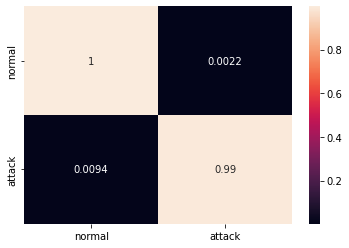

In [25]:
cm = confusion_matrix(y_test, svm_optimal_acc_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Στις Tuned υλοποιήσεις του SVM (μία για βελτιστοποίηση του f1 score και μια για βελτιστοποίηση του accuracy), παρατηρείται εξαιρετικά σημαντική αύξηση των μετρικών f1 score και accuracy σε σχέση με τον αντίστοιχo out of the box. Επομένως, η εύρεση βέλτιστων παραμέτρων αύξησε κατά πολύ την αποδοτικότητα του ταξινομητή. Αυτό επιβεβαιώνεται και με την ανασκόπηση των confusion matrixes, μιας και τα δεδομένα που είναι misclassified, είναι πολύ λιγότερα στα tuned από ότι στο out of the box.

## Out-of-the-box Performance:

In [26]:
ootb_performance = np.array ([[mlp_ootb_f1, mlp_ootb_acc, mlp_ootb_time],
                              [svm_ootb_f1, svm_ootb_acc, svm_ootb_time]])

display(pd.DataFrame(ootb_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.984872,0.990285,7.775491
Support Vector Machine,0.726016,0.869923,28.232895


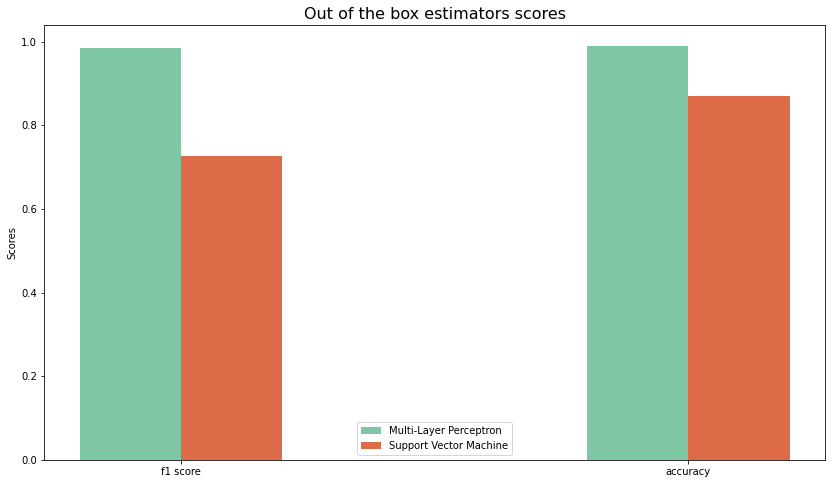

In [27]:
# ootb scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = ootb_performance[0, :2]
y2 = ootb_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score', 'accuracy'])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Out of the box estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Στο ανωτέρω διάγραμμα, συγκρίνονται οι δύο out of the box ταξινομητές με κριτήριο τις μετρικές f1 score και accuracy. Είναι εμφανές, πως ο MLP έχει σημαντικά καλύτερη επίδοση ως προς και τις δύο μετρικές.

## Optimal f1 score model's performance:

In [28]:
optimal_f1_performance = np.array ([[mlp_optimalf1_f1, mlp_optimalf1_acc, mlp_optimal_f1_time],
                              [svm_optimalf1_f1, svm_optimalf1_acc, svm_optimal_f1_time]])

display(pd.DataFrame(optimal_f1_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.992511,0.995142,81.804109
Support Vector Machine,0.993920,0.996087,6.290948


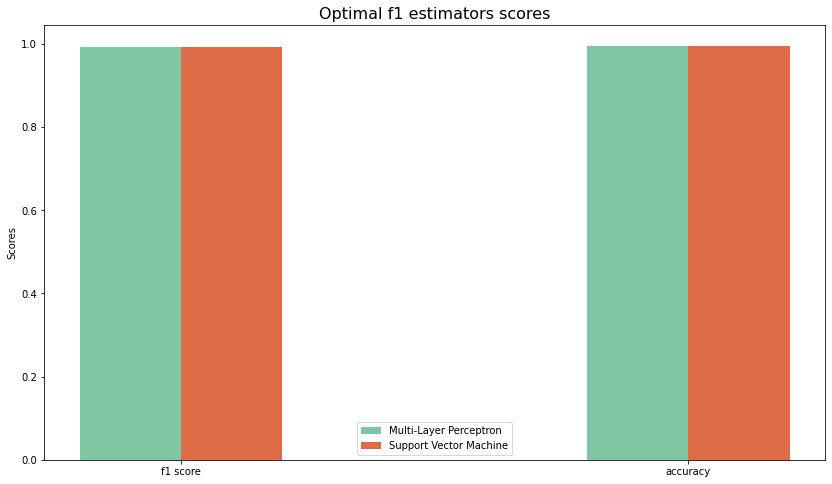

In [29]:
#optimal f1 scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = optimal_f1_performance[0, :2]
y2 = optimal_f1_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score', 'accuracy'])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Optimal f1 estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Στο ανωτέρω διάγραμμα, συγκρίνονται οι δύο optimal f1 score ταξινομητές με κριτήριο τις μετρικές f1 score και accuracy. Οι επιδόσεις του MLP και του SVM είναι πολύ κοντά μεταξύ τους, ενώ παράλληλα είναι πολύ υψηλές (κοντά στο 1).

## Optimal accuracy model's performance:

In [30]:
optimal_acc_performance = np.array ([[mlp_optimalacc_f1, mlp_optimalacc_acc, mlp_optimal_acc_time],
                              [svm_optimalacc_f1, svm_optimalacc_acc, svm_optimal_acc_time]])

display(pd.DataFrame(optimal_acc_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.990449,0.993793,65.977023
Support Vector Machine,0.994343,0.996357,6.658200


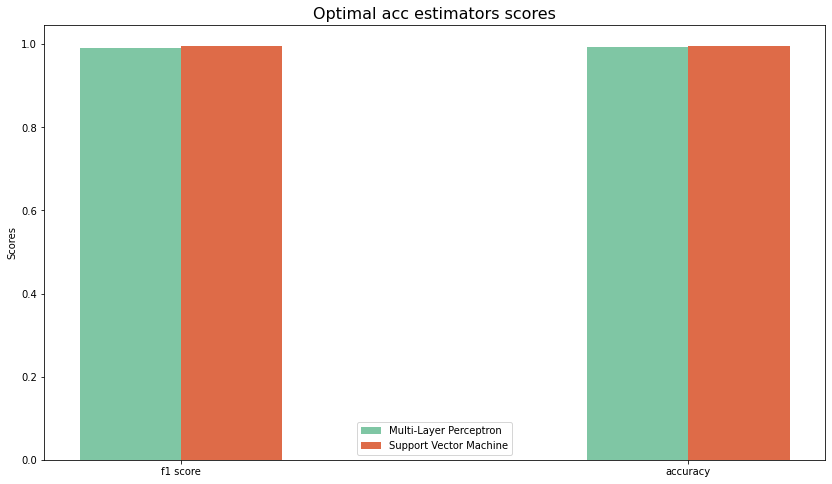

In [31]:
#optimal acc scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = optimal_acc_performance[0, :2]
y2 = optimal_acc_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score', 'accuracy'])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Optimal acc estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Στο ανωτέρω διάγραμμα, συγκρίνονται οι δύο optimal accyracy ταξινομητές με κριτήριο τις μετρικές f1 score και accuracy. Οι επιδόσεις του MLP και του SVM είναι πολύ κοντά μεταξύ τους, ενώ παράλληλα είναι πολύ υψηλές (κοντά στο 1).

## Best Binary Classifier

Για την Binary εκδοχή του προβλήματος, επιλέγουμε ως καλύτερο ταξινομητή τον **SVM-optimal f1 score**, καθώς έχει τόσο καλύτερο f1 score όσο και καλύτερο accuracy από τους tuned MLP, ενώ την ίδια στιγμή απαιτεί υποδεκαπλάσιο χρόνο για εκπαίδευση και πρόβλεψη αποτελεσμάτων. Παρακάτω παραθέτουμε το confussion matrix της τελικής μας επιλογής (του SVM-optimal f1 score):

<AxesSubplot:>

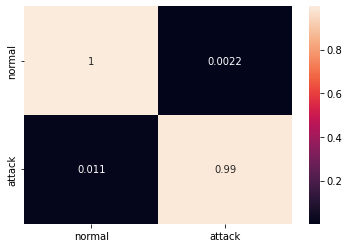

In [32]:
cm = confusion_matrix(y_test, svm_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['normal', 'attack'], ['normal', 'attack'])
sn.heatmap(df_cm, annot=True)

# Multiclass Classification

Σε δεύτερο χρόνο, θα επιχειρήσουμε να εξειδικεύσουμε λίγο το πρόβλημα ως προς τους τύπους των επιθέσεων. Πιο συγκεκριμένα, θα ενοποιήσουμε τις επιθέσεις με βάση κάποιες οικογένειες επιθέσεων, όπως προτείνεται από τη βιβλιογραφία. 

Οι νέες κλάσεις-οικογένειες επιθέσεων είναι οι ακόλουθες: 'dos', u2r', 'r2l' και 'probe', ενώ, προφανώς, η κλάση 'normal' παραμένει ως έχει. Οι αντιστοιχίσεις των επιθέσεων σε αυτές τις οικογένειες φαίνεται και από το παρακάτω mapping.

Παρόλο που έγινε ομαδοποίηση των κλάσεων σε μεγαλύτερες κλάσεις-οικογένειες, παρατηρήσαμε πως κάποιες κλάσεις-οικογένειες έχουν και πάλι μικρό αριθμό δειγμάτων σε σχέση με άλλες. Εφόσον, λοιπόν, επιλέγουμε μόνο ένα μέρος του dataset με στοχαστικό τρόπο, η δυσαναλογία του συνόλου δεδομένων μεταφέρεται (ή ακόμα και κλιμακώνεται) με την επιλογή ενός υποσυνόλου αυτού (5% του αρχικού). Για την εξισορρόπηση του dataset, εκτός του υποσυνόλου του αρχικού dataset, παίρνουμε και **όλα τα δείγματα** (από το αρχικό, ολόκληρο dataset) των μικρών κλάσεων-οικογενειών (εδώ 'u2r' και 'r2l'), καθώς και **1000 δείγματα επιπλέον** του 'probe'. Με τον τρόπο αυτό, εξασφαλίζουμε πως θα έχουμε αρκετά δείγματα για train και test μετά το split και για τις 5 οικογένειες κλάσεων, διατηρώντας παράλληλα το πλεονέκτημα να δουλεύουμε με σχετικά μικρό dataset.

In [33]:
attack_families = {
    "back.": "dos",
    "buffer_overflow.": "u2r",
    "ftp_write.": "r2l",
    "guess_passwd.": "r2l",
    "imap.": "r2l",
    "ipsweep.": "probe",
    "land.": "dos",
    "loadmodule.": "u2r",
    "multihop.": "r2l",
    "neptune.": "dos",
    "nmap.": "probe",
    "perl.": "u2r",
    "phf.": "r2l",
    "pod.": "dos",
    "portsweep.": "probe",
    "rootkit.": "u2r",
    "satan.": "probe",
    "smurf.": "dos",
    "spy.": "r2l",
    "teardrop.": "dos",
    "warezclient.": "r2l",
    "warezmaster.": "r2l",
    "normal.": "normal",
}

# define rare instances
rare_labels_table = ['buffer_overflow.', 'ftp_write.', 'guess_passwd.', 'imap.', 'loadmodule.', 'multihop.', 'perl.', 'phf.', 
               'rootkit.', 'spy.', 'warezclient.', 'warezmaster.']
probe_labels_table = ['ipsweep.', 'nmap.', 'portsweep.', 'satan.']

# get 5% of the dataset
df = df_full.sample(frac=0.05, random_state=0)

# get from the whole df only the rare instances
temp = df_full[df_full.iloc[:, -1].isin(rare_labels_table)]
temp2 = df_full[df_full.iloc[:, -1].isin(probe_labels_table)]
temp2 = temp2.sample(n=1000)

# append to the 5% of the dataset the rare instances
df = df.append(temp)
df = df.append(temp2)

# same as above
features_df = df.iloc[:, :-1]

enc_protocol = pd.get_dummies(features_df["protocoltype"], prefix="protocol_")
enc_service = pd.get_dummies(features_df["service"], prefix="service_")
enc_flag = pd.get_dummies(features_df["flag"], prefix="flag_")

features_df.drop("protocoltype", axis=1, inplace=True)
features_df.drop("service", axis=1, inplace=True)
features_df.drop("flag", axis=1, inplace=True)

features_df = pd.concat([features_df, enc_protocol, enc_service, enc_flag], axis=1)

features = features_df.values

labels_df = df.iloc[:, [-1]]
labels_df = labels_df.replace({"labels": attack_families})
labels = labels_df.values
labels = labels.reshape((labels.shape[0]))

# split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

[13612, 3481, 840, 840, 42]


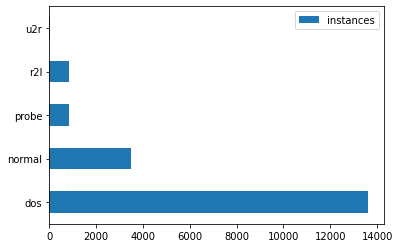

In [34]:
# plot multiclass labels of train set
distinct_labels_mul = ['dos', 'normal', 'probe', 'r2l', 'u2r']

cnt3 = len(distinct_labels_mul)*[0]
# plot instances of train set only
for label in y_train:
    for i, dlabel in enumerate(distinct_labels_mul):
        if label == dlabel:
            cnt3[i] += 1

df = pd.DataFrame({'instances': cnt3}, index=distinct_labels_mul)
ax = df.plot.barh()
print(cnt3)

## Multi-Layer Perceptron (MLP)

### Out-of-the-box

In [35]:
mlp_ootb = MLPClassifier()
start_time = time.time()
mlp_ootb.fit(x_train, y_train)
mlp_ootb_preds = mlp_ootb.predict(x_test)

mlp_ootb_time = time.time() - start_time
print("Total time for fit and predict: %s seconds" % (mlp_ootb_time))

mlp_ootb_acc = accuracy_score(y_test, mlp_ootb_preds)
mlp_ootb_f1 = f1_score(y_test, mlp_ootb_preds, average = 'macro')

print("\nMulti-Layer Perceptron out-of-the-box performance:")
print(classification_report(y_test, mlp_ootb_preds))

Total time for fit and predict: 30.940723419189453 seconds

Multi-Layer Perceptron out-of-the-box performance:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00      5885
      normal       0.98      0.92      0.95      1467
       probe       1.00      0.98      0.99       358
         r2l       0.71      0.93      0.80       337
         u2r       0.50      0.06      0.11        17

    accuracy                           0.98      8064
   macro avg       0.84      0.78      0.77      8064
weighted avg       0.98      0.98      0.98      8064



<AxesSubplot:>

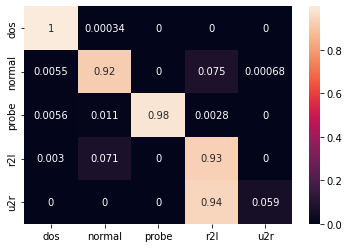

In [36]:
cm = confusion_matrix(y_test, mlp_ootb_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Από το classification report, φαίνεται πως έχουμε έναν καλό ταξινομητή όσον αφορά το accuracy metric, από τη στιγμή που τα περισσότερα δείγματα ταξινομούνται σωστά. Παρόλα αυτά, η out of the box υλοποίηση αυτή, έχει πιο χαμηλό δείκτη f1 macro. Αυτό επιβεβαιώνεται και με την ανασκόπηση του confusion matrix, στον οποίο φαίνεται πως οι κλάσεις 'r2l' και 'u2r' δεν ταξινομούνται με ακρίβεια (ειδικά η τελευταία δεν ταξινομείται σχεδόν ποτέ σωστά). Ο δείκτης f1 macro, συνεπώς, μειώνεται δραματικά, αφού δε λαμβάνει υπόψη τον αριθμό των δειγμάτων σε μια κλάση, αλλά την επιτυχία ταξινόμησης σε όλες τις κλάσεις με την ίδια βαρύτητα.

### Tuned

In [37]:
n_components = [10, 30, 50]
activation = ['relu', 'logistic']
learning_rate_init = [0.01, 0.001, 0.0001]

mlp = MLPClassifier(learning_rate = 'invscaling')
pipe_mlp = Pipeline(steps=[('pca', pca), ('mlp', mlp)])

#### Optimal f1 score:

In [38]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
mlp_optimal_f1 = TuneGridSearchCV(pipe_mlp,  dict(pca__n_components=n_components, mlp__activation=activation, mlp__learning_rate_init=learning_rate_init), max_iters=5, cv=10, scoring='f1_macro')
mlp_optimal_f1.fit(x_train, y_train)
mlp_optimal_f1_time = mlp_optimal_f1.refit_time_

print("\nMulti-Layer Perceptron tuned for optimal f1 performance:")
print(mlp_optimal_f1.best_params_)

start_time = time.time()
mlp_optimal_f1_preds = mlp_optimal_f1.predict(x_test)
mlp_optimal_f1_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (mlp_optimal_f1_time))

mlp_optimalf1_acc = accuracy_score(y_test, mlp_optimal_f1_preds)
mlp_optimalf1_f1 = f1_score(y_test, mlp_optimal_f1_preds, average = 'macro')
print(classification_report(y_test, mlp_optimal_f1_preds))


Multi-Layer Perceptron tuned for optimal f1 performance:
{'pca__n_components': 50, 'mlp__activation': 'relu', 'mlp__learning_rate_init': 0.0001}

Total time for fit and predict: 29.669578790664673 seconds
              precision    recall  f1-score   support

         dos       0.99      1.00      0.99      5885
      normal       0.99      0.94      0.96      1467
       probe       0.98      0.87      0.93       358
         r2l       0.88      0.96      0.92       337
         u2r       0.69      0.53      0.60        17

    accuracy                           0.98      8064
   macro avg       0.91      0.86      0.88      8064
weighted avg       0.98      0.98      0.98      8064



<AxesSubplot:>

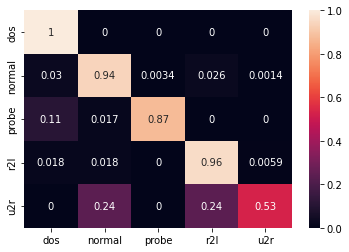

In [39]:
cm = confusion_matrix(y_test, mlp_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

#### Optimal accuracy score:

In [40]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
mlp_optimal_acc = TuneGridSearchCV(pipe_mlp,  dict(pca__n_components=n_components, mlp__activation=activation, mlp__learning_rate_init=learning_rate_init), max_iters=5, cv=10, scoring='accuracy')
mlp_optimal_acc.fit(x_train, y_train)
mlp_optimal_acc_time = mlp_optimal_acc.refit_time_

print("\nMulti-Layer Perceptron tuned for optimal accuracy performance:")
print(mlp_optimal_acc.best_params_)

start_time = time.time()
mlp_optimal_acc_preds = mlp_optimal_acc.predict(x_test)
mlp_optimal_acc_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (mlp_optimal_acc_time))

mlp_optimalacc_acc = accuracy_score(y_test, mlp_optimal_acc_preds)
mlp_optimalacc_f1 = f1_score(y_test, mlp_optimal_acc_preds, average = 'macro')
print(classification_report(y_test, mlp_optimal_acc_preds))


Multi-Layer Perceptron tuned for optimal accuracy performance:
{'pca__n_components': 30, 'mlp__activation': 'logistic', 'mlp__learning_rate_init': 0.0001}

Total time for fit and predict: 68.14845705032349 seconds
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00      5885
      normal       0.96      0.97      0.96      1467
       probe       0.93      0.94      0.94       358
         r2l       0.91      0.91      0.91       337
         u2r       0.00      0.00      0.00        17

    accuracy                           0.98      8064
   macro avg       0.76      0.76      0.76      8064
weighted avg       0.98      0.98      0.98      8064



<AxesSubplot:>

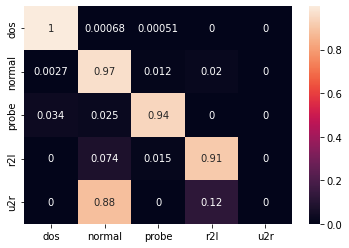

In [41]:
cm = confusion_matrix(y_test, mlp_optimal_acc_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Ο MLP-optimalf1 μεγιστοποιεί το f1 score, εις βάρος του accuracy. Αυτό παρατηρείται και στο αντίστοιχο confusion matrix, όπου οι δύο τελευταίες κλάσεις έχουν υψηλότερες τιμές στη διαγώνιο, "θυσιάζοντας" όμως τις πολύ υψηλές τιμές στις πρώτες κλάσεις. Από την άλλη, ο MLP-optimalaccuracy, μεγιστοποιεί το accuracy εις βάρος του f1 score. Στο αντίστοιχο confusion matrix, διαπιστώνεται υψηλή τιμή στη διαγώνιο των πρώτων τεσσάρων κλάσεων, ενώ στη τελευταία μηδενική.

## Support Vector Machine (SVM)

### Out-of-the-box

In [42]:
svm_ootb = SVC()
start_time = time.time()
svm_ootb.fit(x_train, y_train)
svm_ootb_preds = svm_ootb.predict(x_test)

svm_ootb_time = time.time() - start_time
print("Total time for fit and predict: %s seconds" % (svm_ootb_time))

svm_ootb_acc = accuracy_score(y_test, svm_ootb_preds)
svm_ootb_f1 = f1_score(y_test, svm_ootb_preds, average = 'macro')

print("\nSupport Vector Machine out-of-the-box performance:")
print(classification_report(y_test, svm_ootb_preds))

Total time for fit and predict: 50.44622731208801 seconds

Support Vector Machine out-of-the-box performance:
              precision    recall  f1-score   support

         dos       0.74      1.00      0.85      5885
      normal       0.97      0.09      0.16      1467
       probe       0.00      0.00      0.00       358
         r2l       0.95      0.06      0.11       337
         u2r       0.00      0.00      0.00        17

    accuracy                           0.75      8064
   macro avg       0.53      0.23      0.23      8064
weighted avg       0.76      0.75      0.66      8064



<AxesSubplot:>

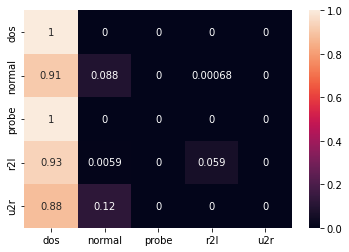

In [43]:
cm = confusion_matrix(y_test, svm_ootb_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Ο out of the box SVM ταξινομητής στο multiclass classification δε δίνει καθόλου καλά αποτελέσματα στις μετρικές. Πιο αναλυτικά, ταξινομεί σχεδόν όλα τα δείγματα στην οικογένεια-κλάσεων "dos", η οποία έχει και τα περισσότερα instances στο train set. Αυτό παρατηρείται και από το παραπάνω confusion matrix, όπου τα περισσότερα δείγματα εντοπίζονται στη πρώτη στήλη.

### Tuned

In [44]:
pca = PCA(whiten=True)
svm = SVC()
pipe_svm = make_pipeline(pca, svm)
parameter_grid = {'pca__n_components': [10, 30, 50],
              'svc__kernel': ['linear', 'rbf'],
              'svc__C': [10, 20, 30]}

#### Optimal f1 score:

In [45]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
svm_optimal_f1 = TuneGridSearchCV(pipe_svm, parameter_grid, max_iters=5, cv=10, scoring='f1_macro')
svm_optimal_f1.fit(x_train, y_train)
svm_optimal_f1_time = svm_optimal_f1.refit_time_

print("\nSupport Vector Machine tuned for optimal f1 performance:")
print(svm_optimal_f1.best_params_)

start_time = time.time()
svm_optimal_f1_preds = svm_optimal_f1.predict(x_test)
svm_optimal_f1_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (svm_optimal_f1_time))

svm_optimalf1_acc = accuracy_score(y_test, svm_optimal_f1_preds)
svm_optimalf1_f1 = f1_score(y_test, svm_optimal_f1_preds, average = 'macro')
print(classification_report(y_test, svm_optimal_f1_preds))


Support Vector Machine tuned for optimal f1 performance:
{'pca__n_components': 30, 'svc__kernel': 'linear', 'svc__C': 30}

Total time for fit and predict: 3.9153780937194824 seconds
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00      5885
      normal       0.99      0.99      0.99      1467
       probe       1.00      0.98      0.99       358
         r2l       0.95      0.98      0.96       337
         u2r       0.81      0.76      0.79        17

    accuracy                           1.00      8064
   macro avg       0.95      0.94      0.95      8064
weighted avg       1.00      1.00      1.00      8064



<AxesSubplot:>

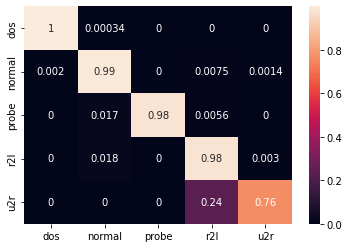

In [46]:
cm = confusion_matrix(y_test, svm_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

#### Optimal accuracy score:

In [47]:
ConvergenceWarning('ignore')
ray.shutdown()
ray.init(log_to_driver=False)
svm_optimal_acc = TuneGridSearchCV(pipe_svm, parameter_grid, max_iters=5, cv=10, scoring='accuracy')
svm_optimal_acc.fit(x_train, y_train)
svm_optimal_acc_time = svm_optimal_acc.refit_time_

print("\nSupport Vector Machine tuned for optimal accuracy performance:")
print(svm_optimal_acc.best_params_)

start_time = time.time()
svm_optimal_acc_preds = svm_optimal_acc.predict(x_test)
svm_optimal_acc_time += time.time() - start_time
print("\nTotal time for fit and predict: %s seconds" % (svm_optimal_acc_time))

svm_optimalacc_acc = accuracy_score(y_test, svm_optimal_acc_preds)
svm_optimalacc_f1 = f1_score(y_test, svm_optimal_acc_preds, average = 'macro')
print(classification_report(y_test, svm_optimal_acc_preds))


Support Vector Machine tuned for optimal accuracy performance:
{'pca__n_components': 30, 'svc__kernel': 'rbf', 'svc__C': 30}

Total time for fit and predict: 2.6017372608184814 seconds
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00      5885
      normal       0.99      0.99      0.99      1467
       probe       1.00      0.97      0.99       358
         r2l       0.98      0.98      0.98       337
         u2r       0.88      0.82      0.85        17

    accuracy                           1.00      8064
   macro avg       0.97      0.95      0.96      8064
weighted avg       1.00      1.00      1.00      8064



<AxesSubplot:>

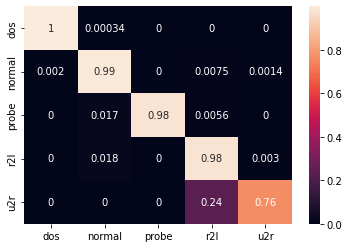

In [48]:
cm = confusion_matrix(y_test, svm_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)

**Παρατηρήσεις**

Τόσο στον SVM-optimal-f1 όσο και στον SVM-optimal-acc παρατηρούνται πολύ υψηλές τιμές των μετρικών f1 score και accuracy. Με εξαίρεση την κατηγορία 'u2r', η οποία έχει τα λιγότερα δείγματα, οι υπόλοιπες έχουν στη διαγώνιο του confusion matrix τιμές >=0.97. Ακόμη και η κατηγορία 'u2r' έχει πολύ υψηλή ακρίβεια σε σχέση με όλες τις προηγούμενες υλοποιήσεις.

## Out-of-the-box performance:

In [49]:
ootb_performance = np.array ([[mlp_ootb_f1, mlp_ootb_acc, mlp_ootb_time],
                              [svm_ootb_f1, svm_ootb_acc, svm_ootb_time]])

display(pd.DataFrame(ootb_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.769208,0.979043,30.940723
Support Vector Machine,0.225238,0.748264,50.446227


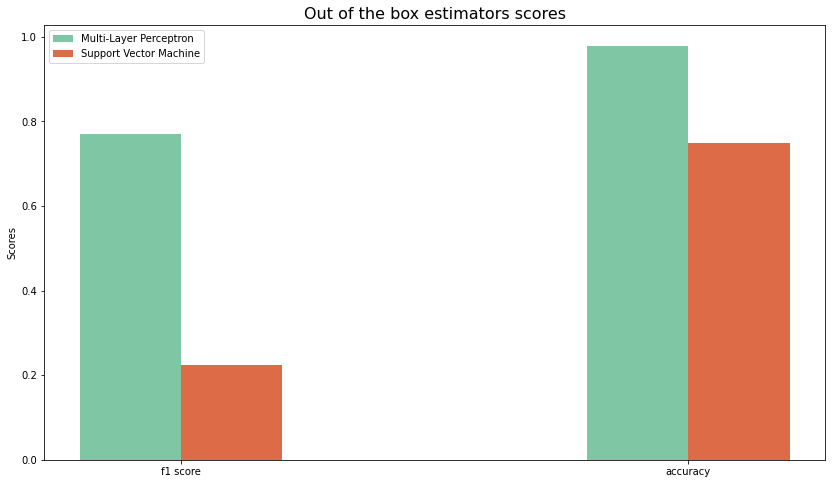

In [50]:
# ootb scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = ootb_performance[0, :2]
y2 = ootb_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score', 'accuracy'])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Out of the box estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Μεταξύ των out of the boxes, με μεγάλη διαφορά διακρίνεται ο MLP και για τις δύο μετρικές.

## Optimal f1 score model's performance:

In [51]:
optimal_f1_performance = np.array ([[mlp_optimalf1_f1, mlp_optimalf1_acc, mlp_optimal_f1_time],
                              [svm_optimalf1_f1, svm_optimalf1_acc, svm_optimal_f1_time]])

display(pd.DataFrame(optimal_f1_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.880412,0.980655,29.669579
Support Vector Machine,0.946167,0.995412,3.915378


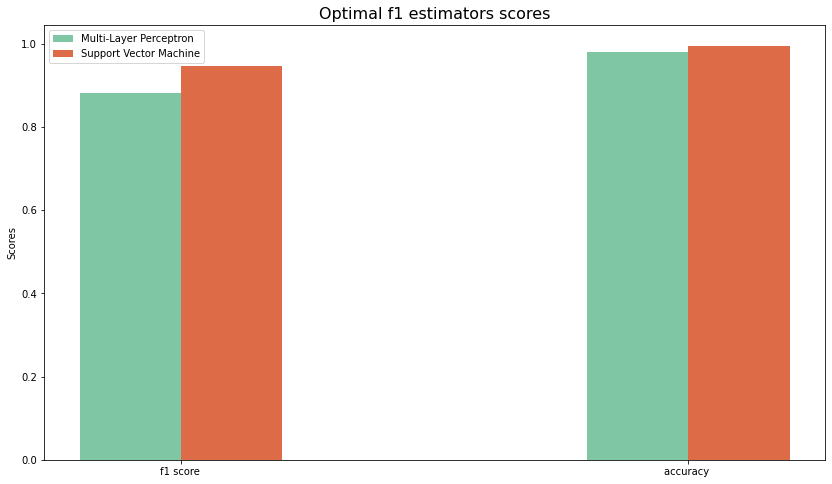

In [52]:
#optimal f1 scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = optimal_f1_performance[0, :2]
y2 = optimal_f1_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score ', 'accuracy '])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Optimal f1 estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Μεταξύ των optimal-f1, διακρίνεται ο SVM, καθώς έχει υψηλότερη τιμή και στις δύο μετρικές. Αξίζει να σημειωθεί, πως η βελτιστοποίηση του SVM με εύρεση των βέλτιστων υπερπαραμέτρων επέφερε εξαιρετικά σημαντική πρόοδο σε σχέση με τον out of the box.

## Optimal accuracy model's performance

In [53]:
optimal_acc_performance = np.array ([[mlp_optimalacc_f1, mlp_optimalacc_acc, mlp_optimal_acc_time],
                              [svm_optimalacc_f1, svm_optimalacc_acc, svm_optimal_acc_time]])

display(pd.DataFrame(optimal_acc_performance, index = ['Multi-Layer Perceptron', 'Support Vector Machine'], columns = ['f1 score','Accuracy','Time']))

,f1 score,Accuracy,Time
Multi-Layer Perceptron,0.761404,0.984375,68.148457
Support Vector Machine,0.960669,0.996156,2.601737


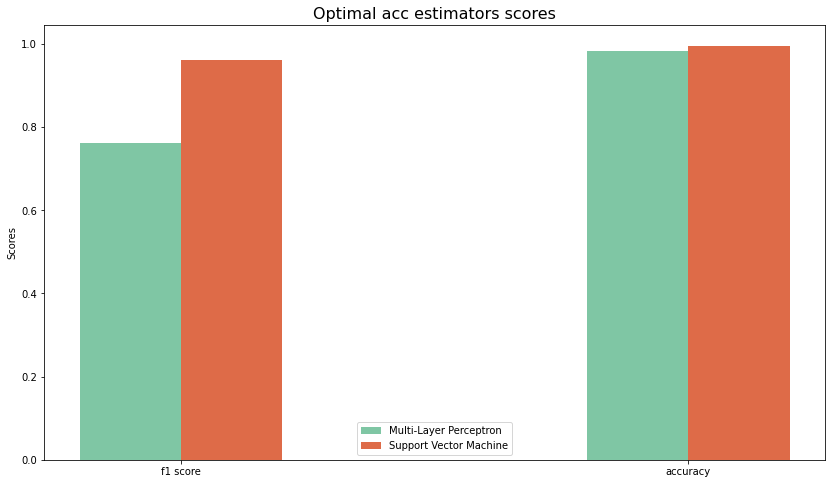

In [54]:
#optimal acc scores
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)
x = np.arange(2)
y1 = optimal_acc_performance[0, :2]
y2 = optimal_acc_performance[1, :2]
width = 0.2

plt.bar(x-0.1, y1, width, color='#7FC6A4')
plt.bar(x+0.1, y2, width, color='#DE6B48')
plt.xticks(x, ['f1 score', 'accuracy'])
plt.ylabel("Scores")
plt.legend(["Multi-Layer Perceptron", "Support Vector Machine"])
plt.title("Optimal acc estimators scores", size=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Παρατηρήσεις**

Μεταξύ των optimal-accuracy, διακρίνεται ο SVM, καθώς έχει υψηλότερη τιμή και στις δύο μετρικές. Αξίζει να σημειωθεί, πως η βελτιστοποίηση του SVM με εύρεση των βέλτιστων υπερπαραμέτρων επέφερε εξαιρετικά σημαντική πρόοδο σε σχέση με τον out of the box.

## Best Multiclass Classifier

Για την Multiclass εκδοχή του προβλήματος, επιλέγουμε ως καλύτερο ταξινομητή τον **SVM-optimal f1 score**, καθώς έχει τόσο καλύτερο f1 score όσο και καλύτερο accuracy από τους tuned MLP, ενώ την ίδια στιγμή απαιτεί υποδεκαπλάσιο χρόνο για εκπαίδευση και πρόβλεψη αποτελεσμάτων. Παρακάτω παραθέτουμε το confusion matrix της τελικής μας επιλογής (του SVM-optimal f1 score):

<AxesSubplot:>

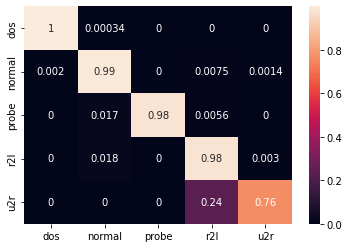

In [55]:
cm = confusion_matrix(y_test, svm_optimal_f1_preds, normalize = 'true')
df_cm = pd.DataFrame(cm, ['dos', 'normal', 'probe', 'r2l', 'u2r'], ['dos', 'normal', 'probe', 'r2l', 'u2r'])
sn.heatmap(df_cm, annot=True)